This notebook trains the face detection model and facial landmarks detection model in Short-sighted Kitten on Google Colab.  
Make sure GPU is selected as Hardware Accelerator before starting.

# Dependencies

Tensorflow 2.1 is used, instead of RC version on Colab, for model compatibility and stability

In [1]:
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 21kB/s 
     |████████████████████████████████| 3.9MB 48.1MB/s 
     |████████████████████████████████| 450kB 48.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7d9bffa7790a75a499da346cf33135726b7a50bccbfbfff735e952c618430b8d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installatio

In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

# Data Pipeline

Download the cleaned dataset from Google Drive.

In [3]:
!gdown --id 1lHJUpAhPCKKWc2BwyXVn84tRaX4_rc19 -O /content/Dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1lHJUpAhPCKKWc2BwyXVn84tRaX4_rc19
To: /content/Dataset.zip
2.17GB [00:29, 73.2MB/s]


In [4]:
!7z x /content/Dataset.zip -o/content


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 2167446058 bytes (2068 MiB)

Extracting archive: /content/Dataset.zip
 20% 4096 Open              --
Path = /content/Dataset.zip
Type = zip
Physical Size = 2167446058

  0%      2% 414 - Dataset/CAT_00/00000026_011.jpg                                            4% 764 - Dataset/CAT_00/00000053_011.jpg                                            5% 1019           6% 1213 - Dataset/CAT_00/00000089_011.jpg.cat       

Construct a TensorFlow input pipeline for the two models.

In [0]:
IMG_SIZE_LANDMARKS = 224
AUTOTUNE = tf.data.experimental.AUTOTUNE

def read_image(img_path):
  img = tf.io.read_file(img_path) # raw bytes for face detection model
  jpg = tf.image.decode_jpeg(img, channels=3) # decoded jpg for facial landmarks model
  jpg = tf.image.convert_image_dtype(jpg, tf.float32)
  shape = tf.cast(tf.shape(jpg)[:2], tf.float32) # [height, width]
  return img, jpg, shape

def read_annotations(img_path):
  annotations_path = tf.strings.regex_replace(img_path, ".jpg", ".jpg.cat")
  line = tf.io.read_file(annotations_path)
  annotations = tf.strings.split(line)[1:] # ignore number of annotations
  annotations = tf.strings.to_number(annotations, tf.float32)
  return annotations

def get_bounding_box(annotations):
  landmarks = tf.reshape(annotations, [-1, 2]) # [[x0, y0], ...]
  # left eye, right, mouth, ear tops
  landmarks = tf.gather(landmarks, [0, 1, 2, 4, 7])
  # [x_min, y_min, x_max, y_max]
  return tf.concat([tf.math.reduce_min(landmarks, axis=0), tf.math.reduce_max(landmarks, axis=0)], axis=0)

def crop_roi(jpg, shape, bounding_box):
  height = shape[0]
  width = shape[1]
  normalized = bounding_box / [width, height, width, height]
  return tf.image.crop_and_resize([jpg], [tf.gather(normalized, [1, 0, 3, 2])], [0], [IMG_SIZE_LANDMARKS, IMG_SIZE_LANDMARKS])[0]

def project_annotations(annotations, bounding_box):
  width = bounding_box[2] - bounding_box[0]
  height = bounding_box[3] - bounding_box[1]

  # shift landmarks wrt bbox
  landmarks = tf.reshape(annotations, [-1, 2])
  landmarks = landmarks - bounding_box[:2]

  # project landmarks from bbox to IMG_SIZE_LANDMARKS
  landmarks = landmarks / [width, height] * [IMG_SIZE_LANDMARKS, IMG_SIZE_LANDMARKS]
  landmarks = tf.reshape(landmarks, [-1])
  return landmarks

def read_cat(img_path):
  img, jpg, shape = read_image(img_path)
  annotations = read_annotations(img_path)
  label = annotations[:6] # left eye, right, mouth

  bounding_box = get_bounding_box(annotations)
  roi = crop_roi(jpg, shape, bounding_box)
  landmarks = project_annotations(annotations, bounding_box)[:6]

  return img, label, bounding_box, shape, roi, landmarks

def get_dataset():
  # split dataset into training, validation, test sets based on folders
  training = tf.data.Dataset.list_files('/content/Dataset/CAT_0[0-4]/*.jpg')\
      .map(read_cat, num_parallel_calls=AUTOTUNE)
  validation = tf.data.Dataset.list_files('/content/Dataset/CAT_05/*.jpg')\
      .map(read_cat, num_parallel_calls=AUTOTUNE)
  test = tf.data.Dataset.list_files('/content/Dataset/CAT_06/*.jpg')\
      .map(read_cat, num_parallel_calls=AUTOTUNE)
  return training, validation, test

def extract_roi_landmarks(_img, _label, _bounding_box, _shape, roi, landmarks):
  return roi, landmarks

def extract_img_bounding_box(img, _label, bounding_box, shape, roi, landmarks):
  return img, bounding_box, shape

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL.ImageDraw import Draw

def chunks(lst, n):
  """Yield successive n-sized chunks from lst."""
  for i in range(0, len(lst), n):
    yield lst[i:i + n]

def show_cat(img, label=None, bounding_box=None):
  img = tf.keras.preprocessing.image.array_to_img(img)
  draw = Draw(img)

  if label is not None:
    for x, y in chunks(label, 2):
      draw.ellipse([(x-5,y-5), (x+5,y+5)], 'cyan')

  if bounding_box is not None:
    draw.rectangle(bounding_box, outline='yellow', width=5)

  plt.imshow(np.asarray(img))
  plt.show()

Inputs for the two models are shown below:

Input of face detection model:
Bounding Box: tf.Tensor([190.   5. 334. 139.], shape=(4,), dtype=float32)
Image:


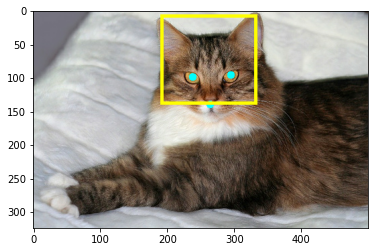

Input of facial landmarks model:
Landmarks: tf.Tensor([ 74.66667  155.46269  163.33334  150.44775  115.111115 224.      ], shape=(6,), dtype=float32)
Face ROI:


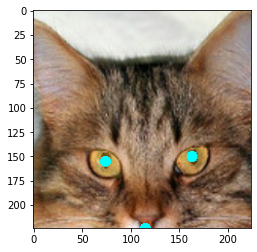

In [23]:
training, validation, test = get_dataset()
for img, label, bounding_box, _shape, roi, landmarks in training.take(1):
  print("Input of face detection model:")
  print("Bounding Box:", bounding_box)
  print("Image:")
  img = tf.image.decode_jpeg(img, channels=3)
  show_cat(img, label=label, bounding_box=bounding_box)

  print("Input of facial landmarks model:")
  print("Landmarks:", landmarks)
  print("Face ROI:")
  show_cat(roi, label=landmarks)

# Face Detection Model

The face detection model predicts the **bounding box of five landmarks**, namely left eye, right eye, mouth, left ear top, and right ear top. The model is an **EfficientDet-D0** model, which is the smallest model in the EfficientDet family, with the backbone trained on ImageNet. To optimize the performance for our problem, the pre-trained model is **fine-tuned** on our dataset with the architecture kept unchanged.

In [0]:
!mkdir /content/face-detection-model
%cd /content/face-detection-model

## Dependencies

Clone EfficientDet repo from Google AI

In [0]:
!git clone --depth 1 https://github.com/google/automl
%cd 'automl/efficientdet'

Cloning into 'automl'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 78 (delta 8), reused 33 (delta 1), pack-reused 0
Unpacking objects: 100% (78/78), done.
/content/automl/efficientdet


In [0]:
!pip install -r requirements.txt
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 5.8MB 6.5MB/s 
     |████████████████████████████████| 2.1MB 39.5MB/s 
     |████████████████████████████████| 276kB 32.7MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=2e7dffe5db529dc2a0d29304c7ec0380d0e97893502824961cf04df5bf0fa95d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-q7tkm0p3
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-q7tkm0p3
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275271 sha256=a5e043ecb431fd85f550cc53d7d80df68ebd986ad62c3fb02c160162095f7a55
  Stored in directory: /tmp/pip-ephem-wheel-cache-8muznev7/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.0
    Uninstalling pycocotools-2.0.0:
      Successfully uninstalled pycocotools-2.0.0


In [0]:
import os
import sys
sys.path.append('.')

Download EfficientDet-D0 checkpoints

In [0]:
MODEL = 'efficientdet-d0'
if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar zxf {MODEL}.tar.gz

--2020-05-08 11:43:43--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28994253 (28M) [application/octet-stream]
Saving to: ‘efficientdet-d0.tar.gz’

efficientdet-d0.tar 100%[===================>]  27.65M  41.3MB/s    in 0.7s    

2020-05-08 11:43:45 (41.3 MB/s) - ‘efficientdet-d0.tar.gz’ saved [28994253/28994253]



## Data Preparation

Serialize the inputs from our data pipeline, since the scripts provided by Google AI accepts TFRecord files only

In [0]:
def int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_list_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def bytes_list_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def float_list_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def serialize_example(img, bounding_box, shape):
  height = shape[0]
  width = shape[1]
  image_format = b'jpg'

  xmins = [bounding_box[0] / width]
  xmaxs = [bounding_box[2] / width]
  ymins = [bounding_box[1] / height]
  ymaxs = [bounding_box[3] / height]
  classes_text = [b'cat']
  classes = [1]

  feature = {
      'image/height': int64_feature(height),
      'image/width': int64_feature(width),
      'image/encoded': bytes_feature(img.numpy()),
      'image/format': bytes_feature(image_format),

      'image/object/bbox/xmin': float_list_feature(xmins),
      'image/object/bbox/xmax': float_list_feature(xmaxs),
      'image/object/bbox/ymin': float_list_feature(ymins),
      'image/object/bbox/ymax': float_list_feature(ymaxs),
      'image/object/class/text': bytes_list_feature(classes_text),
      'image/object/class/label': int64_list_feature(classes),
  }

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

def tf_serialize_example(img, bounding_box, shape):
  tf_string = tf.py_function(
    serialize_example,
    (img, bounding_box, shape),
    tf.string)
  return tf.reshape(tf_string, ())

In [0]:
training, validation, test = get_dataset()
training_detection = training.map(extract_img_bounding_box).map(tf_serialize_example)
validation_detection = validation.map(extract_img_bounding_box).map(tf_serialize_example)
test_detection = test.map(extract_img_bounding_box).map(tf_serialize_example)

!rm -rf cats
!mkdir cats

def reduce_func(key, dataset):
  filename = tf.strings.join([PATH_PREFIX, tf.strings.as_string(key), ".tfrecord"])
  writer = tf.data.experimental.TFRecordWriter(filename)
  writer.write(dataset.map(lambda _, x: x))
  return tf.data.Dataset.from_tensors(filename)

!mkdir cats/train
PATH_PREFIX = "cats/train/"
NUM_SHARDS = 10
training_detection = training_detection.enumerate()
training_detection = training_detection.apply(tf.data.experimental.group_by_window(
  lambda i, _: i % NUM_SHARDS, reduce_func, tf.int64.max
))

!mkdir cats/validation
PATH_PREFIX = "cats/validation/"
NUM_SHARDS = 5
validation_detection = validation_detection.enumerate()
validation_detection = validation_detection.apply(tf.data.experimental.group_by_window(
  lambda i, _: i % NUM_SHARDS, reduce_func, tf.int64.max
))

!mkdir cats/test
PATH_PREFIX = "cats/test/"
NUM_SHARDS = 5
test_detection = test_detection.enumerate()
test_detection = test_detection.apply(tf.data.experimental.group_by_window(
  lambda i, _: i % NUM_SHARDS, reduce_func, tf.int64.max
))

print("Training Set:")
for x in training_detection:
  print(x)

print("Validation Set:")
for x in validation_detection:
  print(x)

print("Test Set:")
for x in test_detection:
  print(x)

Training Set:
tf.Tensor(b'cats/train/0.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/1.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/2.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/3.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/4.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/5.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/6.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/7.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/8.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/train/9.tfrecord', shape=(), dtype=string)
Validation Set:
tf.Tensor(b'cats/validation/0.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/validation/1.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/validation/2.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/validation/3.tfrecord', shape=(), dtype=string)
tf.Tensor(b'cats/validation/4.tfrecord', shape=(), dtype=string)
Test Set:
tf.Tensor(b'cats/test/0.tfrecord', 

Inspect one of the TFRecord files

In [0]:
filenames = ["cats/train/0.tfrecord"]
training_detection = tf.data.TFRecordDataset(filenames)
for example in training_detection.take(1):
  print(tf.train.Example.FromString(example.numpy()))

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000H\000H\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\002\002\003\002\002\002\002\002\004\003\003\002\003\005\004\005\005\005\004\004\004\005\006\007\006\005\005\007\006\004\004\006\t\006\007\010\010\010\010\010\005\006\t\n\t\010\n\007\010\010\010\377\333\000C\001\001\001\001\002\002\002\004\002\002\004\010\005\004\005\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\010\377\300\000\021\010\001\364\001e\003\001\021\000\002\021\001\003\021\001\377\304\000\037\000\000\001\004\002\003\001\001\000\000\000\000\000\000\000\000\000\007\004\005\006\010\003\t\000\002\n\001\013\377\304\000H\020\000\001\003\002\004\004\004\003\006\003\006\005\003\004\002\003\001\002\003\004\005\021\

## Model Training

Fine-tune the model on our dataset.

In [0]:
%%writefile config.yaml
num_classes: 1

Writing config.yaml


In [0]:
!rm -rf saved_model
!python main.py --mode=train_and_eval \
    --training_file_pattern=cats/train/*.tfrecord \
    --validation_file_pattern=cats/validation/*.tfrecord \
    --model_name=efficientdet-d0 \
    --model_dir=saved_model \
    --ckpt=efficientdet-d0 \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples=32 \
    --num_examples_per_epoch=7008 --num_epochs=1  \
    --hparams=config.yaml \
    --use_tpu=False

Streaming output truncated to the last 5000 lines.
I0508 00:59:35.068485 140468465637248 utils.py:102] skip efficientnet-b0/blocks_6/se/conv2d/bias/Momentum (efficientnet-b0/blocks_6/se/conv2d/bias/Momentum) -- not in ckpt
I0508 00:59:35.068567 140468465637248 utils.py:102] skip efficientnet-b0/blocks_6/se/conv2d_1/kernel/Momentum (efficientnet-b0/blocks_6/se/conv2d_1/kernel/Momentum) -- not in ckpt
I0508 00:59:35.068650 140468465637248 utils.py:102] skip efficientnet-b0/blocks_6/se/conv2d_1/bias/Momentum (efficientnet-b0/blocks_6/se/conv2d_1/bias/Momentum) -- not in ckpt
I0508 00:59:35.068734 140468465637248 utils.py:102] skip efficientnet-b0/blocks_6/conv2d_1/kernel/Momentum (efficientnet-b0/blocks_6/conv2d_1/kernel/Momentum) -- not in ckpt
I0508 00:59:35.068818 140468465637248 utils.py:102] skip efficientnet-b0/blocks_6/tpu_batch_normalization_2/gamma/Momentum (efficientnet-b0/blocks_6/tpu_batch_normalization_2/gamma/Momentum) -- not in ckpt
I0508 00:59:35.068901 140468465637248 uti

Export the trained model for inference, which adds several layers not used in the training stage.

In [0]:
!rm -rf inference_model
!python model_inspect.py --runmode=saved_model \
  --model_name=efficientdet-d0 --ckpt_path=saved_model \
  --hparams=config.yaml \
  --saved_model_dir=inference_model

2020-05-08 12:10:33.932250: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-08 12:10:37.164282: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-05-08 12:10:37.164560: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x29f1480 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-08 12:10:37.164599: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-05-08 12:10:37.166878: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-08 12:10:37.221929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-08 12:10:37.222857: I tensorflow/compiler/xla/servic

## Model Evaluation

In [0]:
model = tf.keras.models.load_model('inference_model').signatures['serving_default']

In [0]:
!python main.py --mode=eval \
    --model_name=efficientdet-d0 \
    --model_dir=saved_model \
    --validation_file_pattern=cats/test/*.tfrecord \
    --hparams=config.yaml \
    --eval_timeout=0 \
    --use_tpu=False

2020-05-08 12:12:06.293850: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

W0508 12:12:09.106315 140533571827584 module_wrapper.py:138] From main.py:232: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0508 12:12:09.106721 140533571827584 module_wrapper.py:138] From main.py:237: The name tf.estimator.tpu.InputPipelineConfig is deprecated. Please use tf.compat.v1.estimator.tpu.InputPipelineConfig instead.


W0508 12:12:09.107005 140533571827584 module_wrapper.py:138] From main.py:240: The name tf.estimator.tpu.RunConfig is deprecated. Please use tf.compat.v1.estimator.tpu.RunConfig instead.

I0508 12:12:09.107296 140533571827584 main.py:253] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'input_rand_hflip': True, 'train_scale_min': 0.1, 'train_scale_max': 2.0, 'autoaugment_policy': None, 'use_augmix': False, 'augmix_params': (

# Facial Landmarks Model

The facial landmarks detection model predicts the **coordinates of the three landmarks** used in our project, namely left eye, right eye, and mouth. The model is built on top of an **EfficientNet-B0** model, which is the smallest model in the EfficientNet family, and pre-trained on ImageNet. To optimize the performance for our problem, the pre-trained model is **fine-tuned** with all the layers unfreezed and architecture kept unchanged.

In [32]:
!mkdir /content/facial-landmarks-model
%cd /content/facial-landmarks-model

/content/facial-landmarks-model


## Dependencies

In [25]:
!pip install -U efficientnet

## Data Preparation

In [0]:
MODEL_NAME = "landmarks_model"
IMG_SIZE_LANDMARKS = 224
IMG_SHAPE = (IMG_SIZE_LANDMARKS, IMG_SIZE_LANDMARKS, 3)
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
LEARNING_RATE = 0.001
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [28]:
training, validation, test = get_dataset()
training_batches = training.map(extract_roi_landmarks).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_batches = validation.map(extract_roi_landmarks).batch(BATCH_SIZE).prefetch(AUTOTUNE)
for roi, landmarks in training_batches.take(1):
  print(roi)
  print(landmarks)

tf.Tensor(
[[[[5.71185768e-01 5.05542159e-01 3.55833948e-01]
   [5.57984352e-01 5.15824378e-01 3.45358700e-01]
   [5.93395233e-01 5.43244958e-01 3.71394783e-01]
   ...
   [4.30689394e-01 4.73662049e-01 1.40064567e-01]
   [5.05716205e-01 5.08467317e-01 1.86367556e-01]
   [6.05266392e-01 5.51162779e-01 2.45777786e-01]]

  [[4.92104501e-01 4.56709325e-01 3.19140106e-01]
   [4.47877169e-01 4.40747142e-01 2.74743319e-01]
   [4.82002378e-01 4.55295265e-01 2.74463743e-01]
   ...
   [5.23735046e-01 5.08557439e-01 1.91321239e-01]
   [6.10859275e-01 5.21001279e-01 2.18076408e-01]
   [6.72134042e-01 5.49643219e-01 2.39998490e-01]]

  [[4.07737970e-01 4.07719284e-01 2.53045201e-01]
   [4.01498020e-01 4.14649159e-01 2.38911286e-01]
   [4.31471705e-01 4.22831088e-01 2.57729411e-01]
   ...
   [6.12992823e-01 5.24131775e-01 2.11806223e-01]
   [6.63377106e-01 5.32037377e-01 2.22413585e-01]
   [6.88969076e-01 5.46603560e-01 2.19940141e-01]]

  ...

  [[7.46675134e-01 7.35579610e-01 6.58962548e-01]
   [7

## Model Design

In [29]:
from efficientnet.tfkeras import EfficientNetB0
base_model = EfficientNetB0(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)
base_model.trainable = True

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(6)
], name=MODEL_NAME)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
    loss="mse", 
    metrics=["mse"]
)
model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "landmarks_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 4,230,818
Trainable params: 4,188,802
Non-trainable params: 42,016
_________________________________________________________________


## Model Training

In [0]:
%load_ext tensorboard

In [33]:
from datetime import datetime
log_dir = f"logs/fit/{MODEL_NAME}"
print(log_dir)
!rm -rf {log_dir}
landmarks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, verbose=1,
                                                          monitor='val_loss', mode='min')
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=2*5+3, verbose=1,
                                                       monitor='val_loss', mode='min')

logs/fit/landmarks_model


In [0]:
history = model.fit(
    training_batches, 
    epochs=50, 
    validation_data=validation_batches,
    callbacks=[tensorboard_callback, reduce_lr_callback, early_stop_callback]
)

Train for 219 steps, validate for 40 steps
Epoch 1/50
219/219 [==============================] - 71s 326ms/step - loss: 3250.2767 - mse: 3250.2773 - val_loss: 10107.3738 - val_mse: 10106.4805
Epoch 2/50
219/219 [==============================] - 63s 288ms/step - loss: 1182.1751 - mse: 1182.1753 - val_loss: 1002.5809 - val_mse: 1004.8679
Epoch 3/50
219/219 [==============================] - 62s 284ms/step - loss: 1030.8217 - mse: 1030.8218 - val_loss: 954.6347 - val_mse: 958.3026
Epoch 4/50
219/219 [==============================] - 62s 285ms/step - loss: 981.1222 - mse: 981.1221 - val_loss: 896.4294 - val_mse: 885.5272
Epoch 5/50
219/219 [==============================] - 63s 286ms/step - loss: 924.0014 - mse: 924.0018 - val_loss: 709.4678 - val_mse: 712.8882
Epoch 6/50
219/219 [==============================] - 63s 286ms/step - loss: 590.8855 - mse: 590.8854 - val_loss: 481.5054 - val_mse: 478.9941
Epoch 7/50
219/219 [==============================] - 62s 285ms/step - loss: 403.0214 -

In [0]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 745), started 4:16:26 ago. (Use '!kill 745' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
model.save_weights(f"Checkpoints/{MODEL_NAME}/")

In [0]:
model.save(f"Models/{MODEL_NAME}/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Models/landmarks_model_efficientnet_large_area_unfreezed/assets


## Model Evaluation

In [0]:
saved_model = tf.keras.models.load_model(f"Models/{MODEL_NAME}")

In [0]:
test_batches = test.map(extract_roi_landmarks).batch(BATCH_SIZE)
saved_model.evaluate(test_batches)

41/41 [==============================] - 9s 229ms/step - loss: 16.4010 - mse: 16.3338


[16.40100731500765, 16.333817]

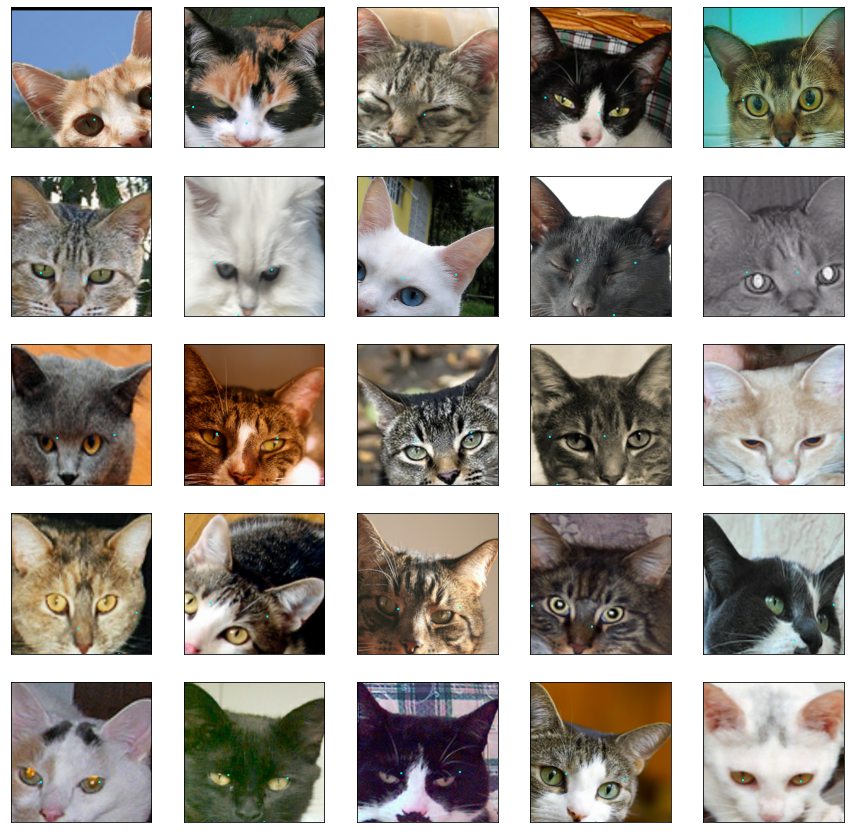

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    test_ds = test.map(extract_roi_landmarks).take(1)
    img, _ = next(iter(test_ds))
    [landmarks] = saved_model.predict(test_ds.batch(1))
    show_cat(img, label=landmarks)
plt.show()

# Model Export

The saved models are available in `/content/face-detection-model/automl/efficientdet/inference_model` and `/content/facial-landmarks/model/Models/landmarks-model`. You may download it or copy to Google Drive.